In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt

from config import DSBConfig
import utils
from utils import DSBDataset
import mask_rcnn as modellib
import visualize
from mask_rcnn import log

Using TensorFlow backend.


In [2]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

TRAIN_PATH = '../dataset/DSB/train/'
TEST_PATH = '../dataset/DSB/test/'

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
train_ids, val_ids = train_test_split(train_ids, test_size=0.1)

In [5]:
config = DSBConfig()
config.STEPS_PER_EPOCH  = len(train_ids)
config.VALIDATION_STEPS = len(val_ids)
config.IMAGE_MAX_DIM = 320
config.display()


Configurations:
BACKBONE_SHAPES                [[80 80]
 [40 40]
 [20 20]
 [10 10]
 [ 5  5]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  320
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           DSB
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000


In [6]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
# Training dataset
dataset_train = DSBDataset()
dataset_train.load_DSB(320, 320, train_ids, TRAIN_PATH)
dataset_train.prepare()

# Validation dataset
dataset_val = DSBDataset()
dataset_val.load_DSB(320, 320, val_ids, TRAIN_PATH)
dataset_val.prepare()

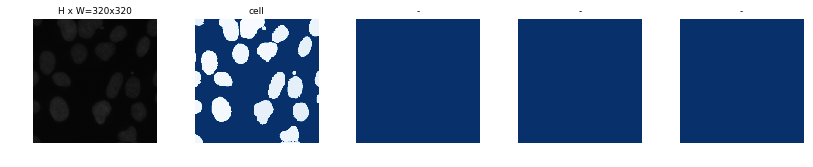

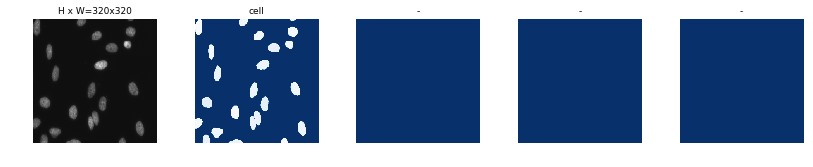

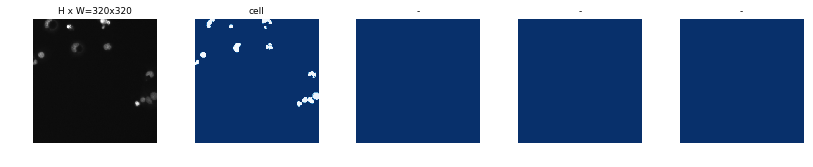

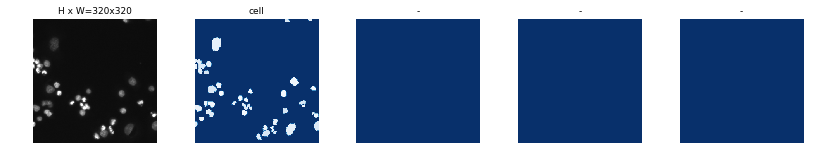

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [9]:
class InferenceConfig(DSBConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
inference_config = InferenceConfig()

In [10]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(
    mode="inference", 
    config=inference_config,
    model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = "./logs/dsb20180309T1156/mask_rcnn_dsb_0010.h5"

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ./logs/dsb20180309T1156/mask_rcnn_dsb_0010.h5


original_image           shape: (320, 320, 3)         min:    1.08000  max:  110.65000
image_meta               shape: (10,)                 min:    0.00000  max:  320.00000
gt_class_id              shape: (8,)                  min:    1.00000  max:    1.00000
gt_bbox                  shape: (8, 4)                min:    2.00000  max:  283.00000
gt_mask                  shape: (320, 320, 8)         min:    0.00000  max:  255.00000


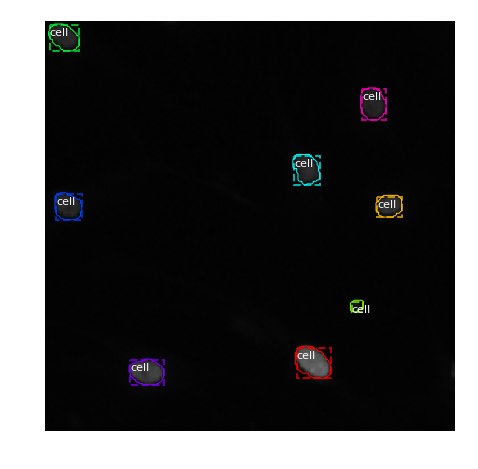

In [11]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(
    dataset_val,
    inference_config, 
    image_id,
    use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(
    original_image,
    gt_bbox,
    gt_mask,
    gt_class_id, 
    dataset_train.class_names,
    figsize=(8, 8))

Processing 1 images
image                    shape: (320, 320, 3)         min:    1.08000  max:  110.65000
molded_images            shape: (1, 320, 320, 3)      min: -122.62000  max:    6.75000
image_metas              shape: (1, 10)               min:    0.00000  max:  320.00000


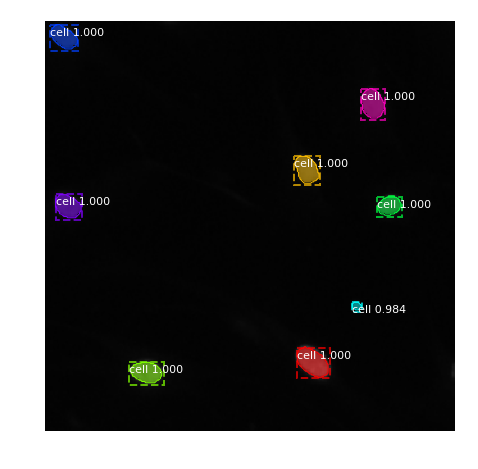

In [12]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(
    original_image,
    r['rois'],
    r['masks'],
    r['class_ids'], 
    dataset_val.class_names,
    r['scores'], ax=get_ax())

In [16]:
from tqdm import tqdm
results = []
for ids in tqdm(test_ids):
    test_img = imread(TEST_PATH + ids + "/images/" +ids + ".png")[:, :, :3]
    r = model.detect([test_img*255], verbose=1)
    r[0]["ids"] = ids
    results.append(r[0])

  3%|▎         | 2/65 [00:00<00:05, 12.28it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:  177.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  247.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  143.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  246.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  142.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000


  6%|▌         | 4/65 [00:00<00:05, 11.79it/s]

Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  150.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Processing 1 images
image                    shape: (519, 162, 3)         min:   51.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000
Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000


  9%|▉         | 6/65 [00:00<00:04, 11.92it/s]

Processing 1 images
image                    shape: (524, 348, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  135.20000
image_metas              shape: (1, 10)               min:    0.00000  max:  524.00000


 11%|█         | 7/65 [00:00<00:06,  9.50it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  246.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  142.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  136.20000
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000


 14%|█▍        | 9/65 [00:00<00:05,  9.46it/s]

Processing 1 images
image                    shape: (524, 348, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  136.20000
image_metas              shape: (1, 10)               min:    0.00000  max:  524.00000


 18%|█▊        | 12/65 [00:01<00:06,  8.54it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  246.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  142.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  254.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  150.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (390, 239, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  390.00000


 22%|██▏       | 14/65 [00:01<00:05,  8.96it/s]

Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  150.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:  135.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (260, 347, 3)         min:    1.00000  max:  230.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  124.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  347.00000


 25%|██▍       | 16/65 [00:01<00:05,  9.07it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:  163.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (520, 348, 3)         min:    1.00000  max:  253.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  148.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  520.00000


 31%|███       | 20/65 [00:02<00:05,  8.90it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  254.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  150.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (520, 348, 3)         min:   70.00000  max:  253.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  149.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  520.00000
Processing 1 images


 32%|███▏      | 21/65 [00:02<00:04,  8.94it/s]

image                    shape: (512, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  150.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  246.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  142.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000


 37%|███▋      | 24/65 [00:02<00:04,  8.91it/s]

Processing 1 images
image                    shape: (519, 161, 3)         min:    1.00000  max:  251.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  146.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000
Processing 1 images
image                    shape: (520, 696, 3)         min:   31.00000  max:  245.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  140.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000


 38%|███▊      | 25/65 [00:02<00:04,  8.87it/s]

Processing 1 images
image                    shape: (520, 696, 3)         min:   26.00000  max:  245.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  141.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000
Processing 1 images
image                    shape: (519, 161, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000


 42%|████▏     | 27/65 [00:03<00:04,  8.87it/s]

Processing 1 images
image                    shape: (520, 348, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  520.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:   64.00000  max:  248.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  144.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  139.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000


 46%|████▌     | 30/65 [00:03<00:04,  8.27it/s]

Processing 1 images
image                    shape: (260, 347, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  143.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  347.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:  174.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000


 51%|█████     | 33/65 [00:03<00:03,  8.45it/s]

Processing 1 images
image                    shape: (519, 253, 3)         min:   31.00000  max:  246.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  142.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000
Processing 1 images
image                    shape: (520, 696, 3)         min:   34.00000  max:  245.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  140.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000


 52%|█████▏    | 34/65 [00:04<00:03,  8.41it/s]

Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  141.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:  255.00000


 55%|█████▌    | 36/65 [00:04<00:03,  8.59it/s]

molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Processing 1 images
image                    shape: (519, 162, 3)         min:    1.00000  max:  253.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  147.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000
Processing 1 images
image                    shape: (524, 348, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  144.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  524.00000


 60%|██████    | 39/65 [00:04<00:03,  8.46it/s]

Processing 1 images
image                    shape: (260, 347, 3)         min:    1.00000  max:  254.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  147.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  347.00000
Processing 1 images
image                    shape: (524, 348, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  143.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  524.00000


 65%|██████▍   | 42/65 [00:04<00:02,  8.48it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (512, 640, 3)         min:  103.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  149.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  140.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000


 66%|██████▌   | 43/65 [00:05<00:02,  8.40it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  254.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  150.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  139.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000


 72%|███████▏  | 47/65 [00:05<00:02,  8.08it/s]

Processing 1 images
image                    shape: (519, 253, 3)         min:   45.00000  max:  245.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  141.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000
Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000
Processing 1 images
image                    shape: (520, 348, 3)         min:    1.00000  max:  251.00000
molded_images            shape: (1, 320, 320, 3)  

 75%|███████▌  | 49/65 [00:06<00:02,  7.91it/s]

Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  144.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000


 80%|████████  | 52/65 [00:06<00:01,  7.86it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  254.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  150.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (519, 253, 3)         min:  155.00000  max:  247.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  142.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000
Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  147.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000


 82%|████████▏ | 53/65 [00:07<00:01,  7.50it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  247.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  143.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  136.20000
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000


 85%|████████▍ | 55/65 [00:07<00:01,  7.54it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  246.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  142.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (520, 696, 3)         min:   19.00000  max:  246.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  141.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000


 91%|█████████ | 59/65 [00:07<00:00,  7.69it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  246.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  142.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  247.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  143.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000


 94%|█████████▍| 61/65 [00:07<00:00,  7.68it/s]

Processing 1 images
image                    shape: (260, 347, 3)         min:    1.00000  max:  228.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  123.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  347.00000
Processing 1 images
image                    shape: (519, 253, 3)         min:   14.00000  max:  245.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  140.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000


 98%|█████████▊| 64/65 [00:08<00:00,  7.78it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:  161.00000  max:  255.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  247.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  143.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  247.00000
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  143.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  288.00000


100%|██████████| 65/65 [00:08<00:00,  7.81it/s]
